In [62]:
import numpy as np
import numba
from plotly import graph_objects as go
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/nik/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['size', 'f']
`%matplotlib` prevents importing * from pylab and numpy



In [31]:
@numba.njit
def mcmove(config, beta=0.4):
    '''Monte Carlo move using Metropolis algorithm '''
    N = len(config)
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config


@numba.njit
def _ising_update(field, n, m, beta):
    total = 0
    N, M = field.shape
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif np.exp(-dE * beta) > np.random.rand():
        field[n, m] *= -1

In [54]:

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

def metropolis_mc(equilibrium_steps=0, sample_size=1000,
                  beta=0.4, size=(700, 700), verbose=False):
    if verbose:
        print('sampling...')
    images = [random_spin_field(size[0], size[1])]
    n_steps=equilibrium_steps + sample_size
    for i in tqdm(range(n_steps)):
        images.append(mcmove(images[-1].copy(), beta=beta))
        if i == equilibrium_steps and verbose:
            print('equilibrium is reached')
    return images[equilibrium_steps:]
images = metropolis_mc(beta=2, verbose=True)

sampling...


equilibrium is reached



In [15]:
from PIL import Image

In [16]:
from ipywidgets import interact

def display_ising_sequence(images):
    def _show(frame=(0, len(images) - 1)):
        return display_spin_field(images[frame])
    return interact(_show)

In [55]:
def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) * 0.5 * 255))

display_ising_sequence(images)


interactive(children=(IntSlider(value=500, description='frame', max=1000), Output()), _dom_classes=('widget-in…

<function __main__.display_ising_sequence.<locals>._show(frame=(0, 1000))>

In [34]:
@numba.njit
def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    N = len(config)
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j]\
                 + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.

@numba.njit
def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag


In [41]:
Temperatures = np.linspace(1.53, 3., 40)
k_b = 1.3806e-23
sample_size = 500
size = 200
equilibrium_steps = 500

Energies = np.zeros(len(Temperatures))
Magnetisaisions = np.zeros(len(Temperatures))
SpecificHeat = np.zeros(len(Temperatures))
Susceptibility = np.zeros(len(Temperatures))

n1, n2  = 1.0 / (sample_size * size**2), 1.0 / (sample_size**2 * size**2) 


for idx, T in tqdm(enumerate(Temperatures), total=len(Temperatures)):
    E1 = M1 = E2 = M2 = 0
    
    iT = 1 / T
    iT2 = iT * iT
    
    
    
    for state in metropolis_mc(equilibrium_steps=equilibrium_steps,\
                               sample_size=sample_size, beta=iT, size=(size, size)):
                  
        Ene = calcEnergy(state)     # calculate the energy
        Mag = calcMag(state)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

    Energies[idx] = n1 * E1
    Magnetisaisions[idx] = n1 * M1
    SpecificHeat[idx] = (n1 * E2 - n2 * E1 * E1) * iT2
    Susceptibility[idx] = (n1 * M2 - n2 * M1 * M1) * iT


    


In [71]:
## change these parameters for a smaller (faster) simulation 
temperature_number      = 88         #  number of temperature poitemperature_numbers
N       = 50         #  size of the lattice, N x N
eqSteps = 10240*3      #  number of MC sweeps for equilibration
mcSteps = 1024*3       #  number of MC sweeps for calculation

T       = np.linspace(1.53, 3.28, temperature_number); 
E,M,C,X = np.zeros(temperature_number), np.zeros(temperature_number), np.zeros(temperature_number), np.zeros(temperature_number)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N) 
# divide by number of samples, and by system size to get itemperature_numberensive values

In [72]:

for idx in tqdm(range(temperature_number)):
    E1 = M1 = E2 = M2 = 0
    config = random_spin_field(N, N)
    iT=1.0/T[idx]
    iT2=iT*iT
    
    for i in range(eqSteps):         
        mcmove(config, iT)           

    for i in range(mcSteps):
        mcmove(config, iT)           
        Ene = calcEnergy(config)     
        Mag = calcMag(config)        

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

    E[idx] = n1*E1
    M[idx] = n1*M1
    C[idx] = (n1*E2 - n2*E1*E1)*iT2
    X[idx] = (n1*M2 - n2*M1*M1)*iT

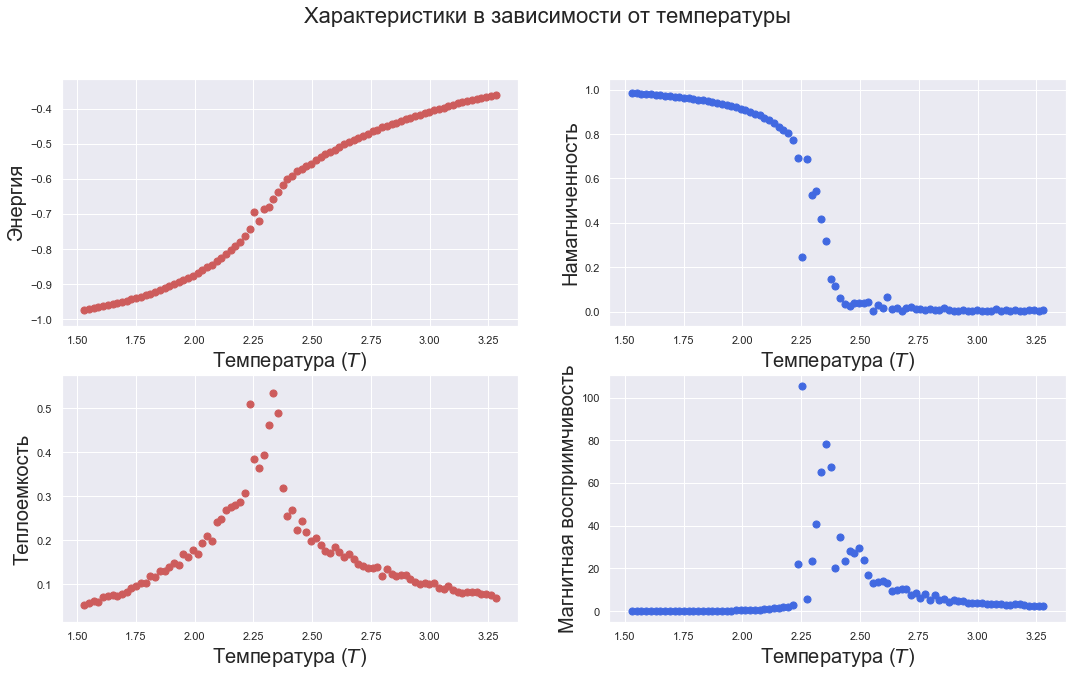

In [73]:
f = plt.figure(figsize=(18, 10));

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel(r"Температура ($T$)", fontsize=20);
plt.ylabel("Энергия", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel(r"Температура ($T$)", fontsize=20); 
plt.ylabel("Намагниченность", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel(r"Температура ($T$)", fontsize=20);  
plt.ylabel("Теплоемкость", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel(r"Температура ($T$)", fontsize=20); 
plt.ylabel("Магнитная восприимчивость", fontsize=20);   plt.axis('tight');
plt.suptitle('Характеристики в зависимости от температуры', fontsize=22)
plt.show()